In [1]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import numpy as np

### Function Definitions

Next, we define some functions that we will use later in the notebook. It also contains some variables that we will use later.

In [37]:
STAGES = ["No DR", "Mild", "Moderate", "Severe", "Proliferative DR"]

In [2]:
IMG_SIZE = 224

In [3]:
# Define paths to images and labels
train_image_dir = (
    "/kaggle/input/resized-2015-2019-blindness-detection-images/resized train 19"
)
train_label_file = "/kaggle/input/resized-2015-2019-blindness-detection-images/labels/trainLabels19.csv"

In [4]:
# Load labels into a pandas dataframe
labels_df = pd.read_csv(train_label_file)

# Create a dictionary mapping image IDs to labels
label_dict = dict(zip(labels_df["id_code"], labels_df["diagnosis"]))

In [5]:
# Define a function to load and preprocess images
def load_and_preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image /= 255.0
    return image

In [6]:
# Define a function to get the label for an image
def get_label(image_path):
    image_id = os.path.basename(image_path).split(".")[0]
    res = np.zeros(5)
    res[label_dict[image_id]] = 1
    return res

In [7]:
# Get a list of image paths
image_paths = [
    os.path.join(train_image_dir, filename) for filename in os.listdir(train_image_dir)
]

In [8]:
# Split the dataset into training, validation, and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths,
    [get_label(path) for path in image_paths],
    test_size=0.2,
    random_state=42,
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=42
)

In [9]:
# Create a dataset of image paths
train_paths_ds = tf.data.Dataset.from_tensor_slices(train_paths)
val_paths_ds = tf.data.Dataset.from_tensor_slices(val_paths)
test_paths_ds = tf.data.Dataset.from_tensor_slices(test_paths)

In [10]:
# Load and preprocess the images
train_images_ds_1 = train_paths_ds.map(load_and_preprocess_image)
val_images_ds_1 = val_paths_ds.map(load_and_preprocess_image)
test_images_ds_1 = test_paths_ds.map(load_and_preprocess_image)

### Data Preprocessing (Circular Cropping and Gaussian Blur)

We will now preprocess the images. We will first crop the images to a circular shape and then apply a Gaussian blur to the images. We will also resize the images to 224x224 pixels.

In [11]:
"""
This Function performs image processing on top of images by performing Gaussian Blur and Circle Crop
reference - https://www.kaggle.com/ratthachat/aptos-eye-preprocessing-in-diabetic-retinopathy#3.-Further-improve-by-auto-cropping
https://github.com/debayanmitra1993-data/Blindness-Detection-Diabetic-Retinopathy-/blob/master/1_eda.ipynb
"""


def crop_image_from_gray(img, tol=7):
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1), mask.any(0))]
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol

        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image is too dark so that we crop out everything,
            return img  # return original image
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))]
            img2 = img[:, :, 1][np.ix_(mask.any(1), mask.any(0))]
            img3 = img[:, :, 2][np.ix_(mask.any(1), mask.any(0))]
            img = np.stack([img1, img2, img3], axis=-1)
        return img


def circle_crop(img, sigmaX):
    """
    Create circular crop around image centre
    """
    img = img.numpy()
    img = crop_image_from_gray(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img = cv2.addWeighted(img, 4, cv2.GaussianBlur(img, (0, 0), float(sigmaX)), -4, 0.5)
    return img

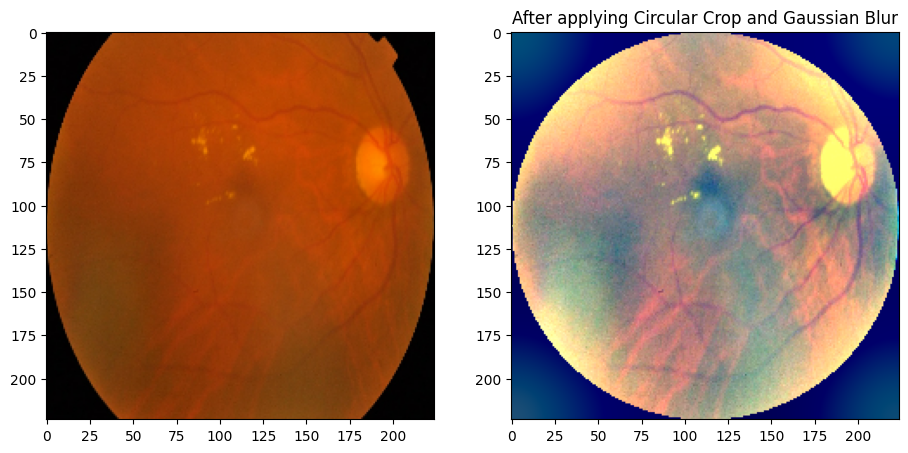

In [12]:
"""Perform Image Processing on a sample image"""
img = list(train_images_ds_1.take(1))[0]
# img = img_t
img_t = circle_crop(img, sigmaX=30)

f, axarr = plt.subplots(1, 2, figsize=(11, 11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title("After applying Circular Crop and Gaussian Blur")
plt.show()

In [13]:
# Apply the function over the dataset
train_images_ds = train_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)
val_images_ds = val_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)
test_images_ds = test_images_ds_1.map(
    lambda x: tf.py_function(circle_crop, [x, 30], tf.float32)
)

In [14]:
# Combine the images and labels into a single dataset
train = tf.data.Dataset.zip(
    (train_images_ds, tf.data.Dataset.from_tensor_slices(train_labels))
)
val = tf.data.Dataset.zip(
    (val_images_ds, tf.data.Dataset.from_tensor_slices(val_labels))
)
test = tf.data.Dataset.zip(
    (test_images_ds, tf.data.Dataset.from_tensor_slices(test_labels))
)

In [15]:
train = train.batch(8)
train = train.prefetch(4)

In [16]:
test = test.batch(8)
test = test.prefetch(4)

In [17]:
val = val.batch(8)
val = val.prefetch(4)

In [18]:
train.as_numpy_iterator().next()

(array([[[[ 0.01044959,  0.3102799 ,  0.4783629 ],
          [ 0.01002103,  0.3101172 ,  0.47834766],
          [ 0.00873643,  0.3096295 ,  0.47830197],
          ...,
          [-0.07570404,  0.27072573,  0.48568112],
          [-0.07431048,  0.27126545,  0.48570934],
          [-0.07384574,  0.2714454 ,  0.4857188 ]],
 
         [[ 0.01006496,  0.31012863,  0.47834396],
          [ 0.00963652,  0.3099659 ,  0.47832873],
          [ 0.00835177,  0.30947804,  0.47828308],
          ...,
          [-0.07619137,  0.2705295 ,  0.48567066],
          [-0.07479763,  0.27106935,  0.48569888],
          [-0.07433307,  0.27124926,  0.48570833]],
 
         [[ 0.00891212,  0.3096748 ,  0.47828716],
          [ 0.00848344,  0.30951196,  0.4782719 ],
          [ 0.00719824,  0.30902392,  0.47822624],
          ...,
          [-0.07765359,  0.26994127,  0.4856393 ],
          [-0.07625943,  0.2704813 ,  0.4856675 ],
          [-0.07579428,  0.27066132,  0.4856769 ]],
 
         ...,
 
         [[ 

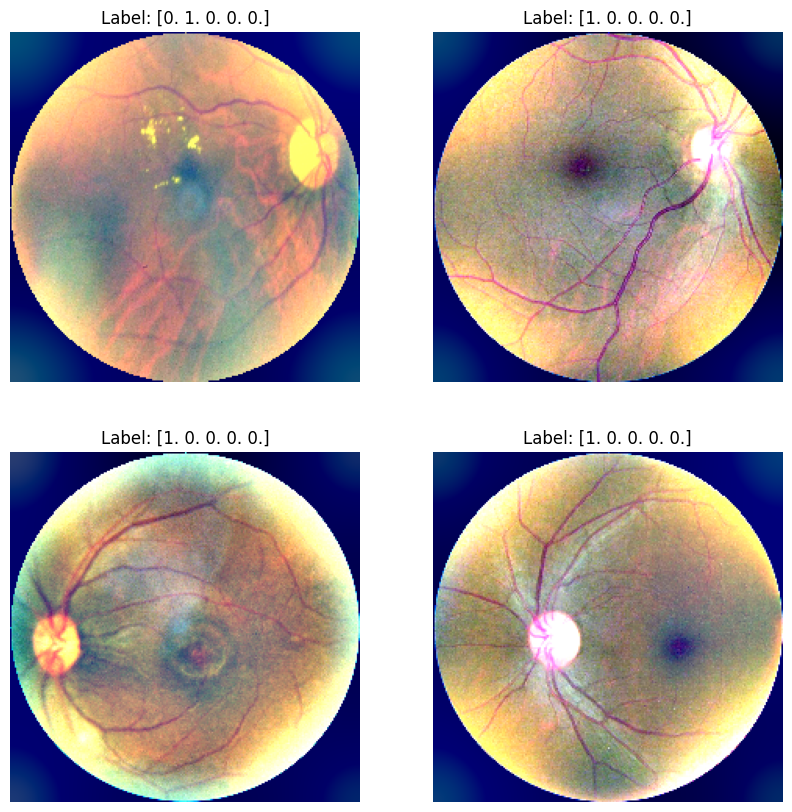

In [19]:
# Assuming the train_dataset is already loaded
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
train_plot = train.take(4)
for (img, label), ax in zip(train_plot, axs):
    ax.imshow(img.numpy()[0])
    ax.set_title(f"Label: {label.numpy()[0]}")
    ax.axis("off")

plt.show()

### Build the model using TensorFlow Functional API

Here, we build the model on top of ResNet50 using the TensorFlow Functional API. We will use the pre-trained weights of ResNet50 as the initial weights for our model.

In [20]:
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
WARMUP_EPOCHS = 3

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [30]:
def build_model():
    # Load the pre-trained ResNet50 model
    base_model = ResNet50(
        weights="imagenet", include_top=False, input_shape=(224, 224, 3)
    )

    # Add a global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer with 2048 neurons and ReLU activation
    x = Dense(2048, activation="relu")(x)

    # Dropout by 0.5
    x = Dropout(0.5)(x)

    # Add an output layer with 5 neurons (for the 5 classes) and softmax activation
    predictions = Dense(5, activation="softmax")(x)

    # Create the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [32]:
model = build_model()

In [34]:
for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

In [35]:
model.summary()

Model: "model_2"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                

                                                                                                  

 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              

                                )                                                                 

                                                                                 

### Train the model

We will now train the model. We will use the Adam optimizer with a learning rate of 0.0001 and the categorical cross-entropy loss function. We will also use the ReduceLROnPlateau callback to reduce the learning rate by a factor of 0.5 if the validation loss does not improve for 3 epochs.

In [40]:
# Warm up the model to make our new layers get some initial training
model.compile(
    optimizer=optimizers.Adam(lr=WARMUP_LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

history_warmup = model.fit(train, validation_data=val, epochs=WARMUP_EPOCHS)

Epoch 1/3

293/293 [==============================] - 63s 200ms/step - loss: 1.4830 - accuracy: 0.4494 - val_loss: 1.1827 - val_accuracy: 0.5358

Epoch 2/3

293/293 [==============================] - 59s 201ms/step - loss: 1.2614 - accuracy: 0.5113 - val_loss: 1.1271 - val_accuracy: 0.5375

Epoch 3/3

293/293 [==============================] - 59s 200ms/step - loss: 1.2040 - accuracy: 0.5348 - val_loss: 1.0896 - val_accuracy: 0.5427


In [43]:
# now make all layers trainable
for layer in model.layers:
    layer.trainable = True

In [44]:
es = EarlyStopping(
    monitor="val_loss", mode="min", patience=5, restore_best_weights=True, verbose=1
)
rlrop = ReduceLROnPlateau(
    monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-6, verbose=1
)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"

__________________________________________________________________________________________________

 Layer (type)                   Output Shape         Param #     Connected to                     


 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               

                                )]                                                                

                                                                                                  

 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                

                                                                                                  

 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              

                                )                                                                 

                                                                                 

In [45]:
history_finetunning = model.fit(
    train, validation_data=val, epochs=40, callbacks=callback_list, verbose=1
)

Epoch 1/40

293/293 [==============================] - 103s 233ms/step - loss: 0.3718 - accuracy: 0.6675 - val_loss: 2.5032 - val_accuracy: 0.5358 - lr: 0.0010

Epoch 2/40

293/293 [==============================] - 68s 232ms/step - loss: 0.2651 - accuracy: 0.7145 - val_loss: 0.4326 - val_accuracy: 0.5734 - lr: 0.0010

Epoch 3/40

293/293 [==============================] - 67s 230ms/step - loss: 0.2451 - accuracy: 0.7401 - val_loss: 0.2350 - val_accuracy: 0.7423 - lr: 0.0010

Epoch 4/40

293/293 [==============================] - 67s 230ms/step - loss: 0.2196 - accuracy: 0.7614 - val_loss: 0.7769 - val_accuracy: 0.6058 - lr: 0.0010

Epoch 5/40

293/293 [==============================] - 68s 232ms/step - loss: 0.2064 - accuracy: 0.7717 - val_loss: 0.1831 - val_accuracy: 0.8072 - lr: 0.0010

Epoch 6/40

293/293 [==============================] - 69s 236ms/step - loss: 0.2066 - accuracy: 0.7776 - val_loss: 0.5640 - val_accuracy: 0.5648 - lr: 0.0010

Epoch 7/40

293/293 [==================

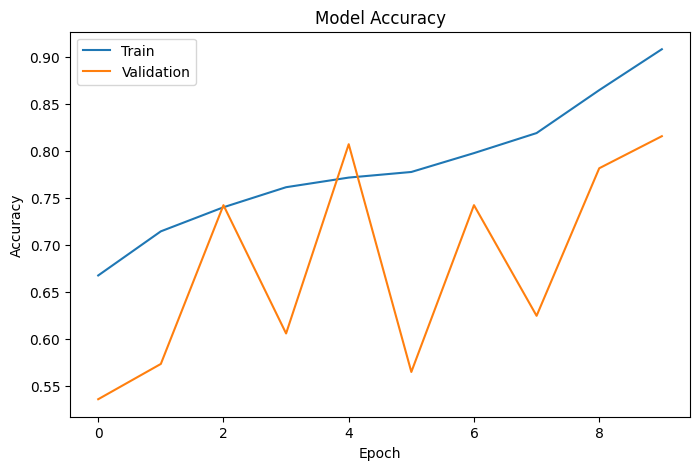

In [47]:
# ref - https://stackoverflow.com/questions/29188757/matplotlib-specify-format-of-floats-for-tick-lables
plt.figure(figsize=(8, 5))

plt.plot(history_finetunning.history["accuracy"])
plt.plot(history_finetunning.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.gca().ticklabel_format(axis="both", style="plain", useOffset=False)
plt.show()

In [49]:
model.save("blindnessdetection.h5")

In [22]:
# loading the model later
from tensorflow.keras.models import load_model

model = load_model("blindnessdetection.h5")

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  318M  100  318M    0     0  7713k      0  0:00:42  0:00:42 --:--:-- 12.8M  38057      0  2:26:17  0:00:01  2:26:16 38084


In [57]:
test_iter = test.as_numpy_iterator()
test_plot = test_iter.next()

In [58]:
pred = model.predict(test_plot[0])

1/1 [==============================] - 0s 33ms/step


In [59]:
pred.shape

(8, 5)

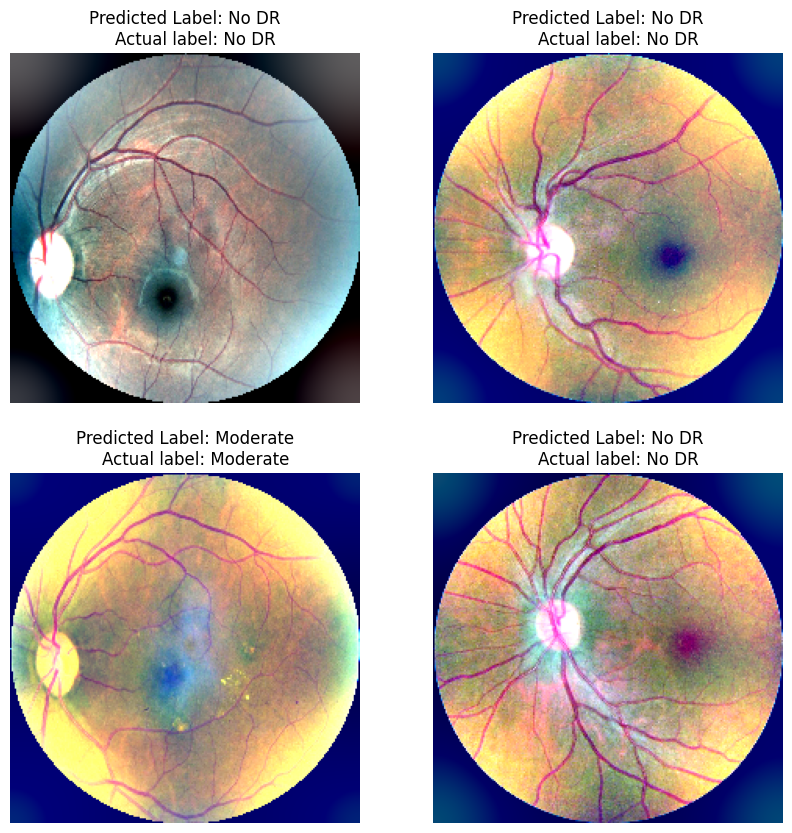

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for n, ax in enumerate(axs):
    ax.imshow(test_plot[0][n])
    ax.set_title(
        f"""Predicted Label: {STAGES[np.argmax(pred[n])]}
    Actual label: {STAGES[np.argmax(test_plot[1][n])]}"""
    )
    ax.axis("off")

plt.show()